In [1]:
%matplotlib inline

import numpy as np
import seaborn as sns
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib
import math

import copy # copy.deepcopy(dict_variable) to actually copy a dict without problems

import keijzer_exogan as ke

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# Load chunk
X[0] is a dict from regular chunk  
X[0][0] is a dict from .npy selection  

In [2]:
dir_ = '/datb/16011015/ExoGAN_data//'

X = ke.load_all_to_array(dir_,'chunck_0.pkgz')

100%|██████████| 1/1 [00:11<00:00, 11.91s/it]


In [3]:
df = pd.read_csv('wavelengths_and_indices.csv', header=None, skiprows=[0], usecols=[1]) # load wavelengths
df.columns = ['x']
df = df.loc[df['x'] <= 16] # select only wavelengths <= 16

## Dict to ASPA function

In [4]:
def ASPA_v3(x, wavelengths, max_wavelength=16):
    """
    x: dict 
    y: ?
    max_wavelength: max wavelength in micron to decode in aspa
    
    returns: 1x32x32 ndarray
    """
    
    #print('='*100)
    x = copy.deepcopy(x)
    wavelengths = wavelengths.copy()
    
    spectrum = x['data']['spectrum']
    #print('Original spectrum length: ', len(spectrum))
    spectrum = np.expand_dims(spectrum, axis=1) # change shape from (515,) to (515,1)
    params = x['param']

    for param in params:
        #print('Param: ', param)
        if 'mixratio' in param: 
            params[param] = np.log(np.abs(params[param])) # transform mixratio's because they are generated on logarithmic scale
    
    """
    Normalize params
    """
    # Min max values from training set, in the same order as params above: planet mass, temp, .... co mixratio.
    min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
    max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

    for i,param in enumerate(params):
        params[param] = scale_param(params[param], min_values[i], max_values[i])
        #print('%s: %s' % (param, params[param]))
        
    #print('-'*5)
    """
    Select bins
    """
    data = np.concatenate([wavelengths,spectrum], axis=1)
    #print('Original data length: ', len(data))
    data = pd.DataFrame(data)
    data.columns = ['x', 'y'] # x is wavelength, y is (R_p / R_s)^2
    data = data.loc[data['x'] <= 16] # select only wavelengths <= 16
    
    # Could loop this, but right now this is more visual
    bin1 = data[data.x <= 0.8]
    bin2 = data[(data.x > 0.8) & (data.x <= 1.3)] # select data between 2 and 4 micron
    bin3 = data[(data.x > 1.3) & (data.x <= 2)]
    bin4 = data[(data.x > 2) & (data.x <= 4)]
    bin5 = data[(data.x > 4) & (data.x <= 6)]
    bin6 = data[(data.x > 6) & (data.x <= 10)]
    bin7 = data[(data.x > 10) & (data.x <= 14)]
    bin8 = data[data.x > 14]

    bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]
    #print('Total bins length: ', len(np.concatenate(bins)))
    """
    Normalize bins
    """
    scalers = [MinMaxScaler(feature_range=(0,1)).fit(b) for b in bins] # list of 8 scalers for the 8 bins
    mins = [ b.iloc[:,1].min() for b in bins] # .iloc[:,1] selects the R/R (y) only
    maxs = [ b.iloc[:,1].max() for b in bins]
    stds = [ b.iloc[:,1].std() for b in bins]
    #print(min(mins), max(maxs))
    bins_scaled = []
    for i,b in enumerate(bins):
        bins_scaled.append(scalers[i].transform(b))
        
    spectrum_scaled = np.concatenate(bins_scaled, axis=0)
    spectrum_scaled = spectrum_scaled[:,1]
    #print('spectrum scaled shape: ', spectrum_scaled.shape)
    
    """
    Create the ASPA
    """
    
    """Spectrum"""
    aspa = np.zeros((32,32))

    row_length = 25 # amount of pixels used per row
    n_rows = math.ceil(len(spectrum_scaled) / row_length) # amount of rows the spectrum needs in the aspa, so for 415 data points, 415/32=12.96 -> 13 rows
    #print('Using %s rows' % n_rows)

    for i in range(n_rows): # for i in 

        start = i*row_length
        stop = start+row_length
        spec = spectrum_scaled[start:stop]

        if len(spec) != row_length:
            n_missing_points = row_length-len(spec)
            spec = np.append(spec, [0 for _ in range(n_missing_points)]) # for last row, if length != 32, fill remaining with 0's
            #print('Filled row with %s points' % n_missing_points)

        aspa[i, :row_length] = spec
        
    """ExoGAN params"""
    for i,param in enumerate(params):
        aspa[:16, 25+i:26+i] = params[param]
        
    """min max std values for spectrum bins"""
    for i in range(len(mins)):
        min_ = scale_param(mins[i], 0.005, 0.03)
        max_ = scale_param(maxs[i], 0.005, 0.03)
        std_ = scale_param(stds[i], 9e-6, 2e-4)

        aspa[16:17, i*4:i*4+4] = min_
        aspa[17:18, i*4:i*4+4] = std_
        aspa[18:19, i*4:i*4+4] = max_
        
    """Fill unused space with noice"""
    for i in range(13):
        noise = np.random.rand(32) # random noise betweem 0 and 1 for each row
        aspa[19+i:20+i*1, :] = noise
        
    return aspa

In [5]:
def scale_param(X, X_min, X_max):
    """
    Formule source: 
    https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    
    In this case 1 is max, 0 is min
    """
    std = (X-X_min)/ (X_max - X_min)
    return std*(1 - 0)+0

In [6]:
wavelengths = pd.read_csv(dir_+'wnw_grid.txt', header=None).values

100%|██████████| 16/16 [00:01<00:00,  5.51it/s]


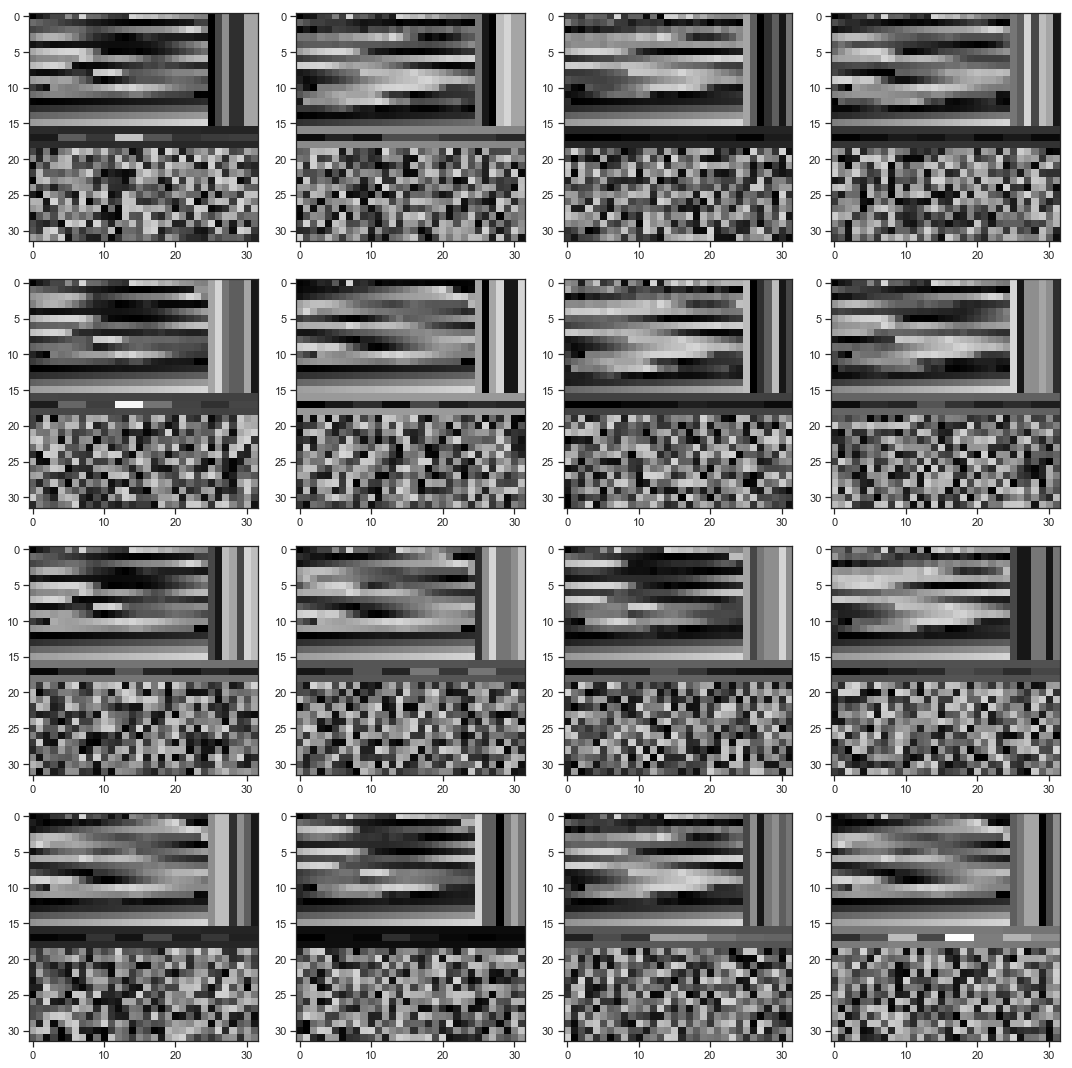

In [7]:
np.random.shuffle(X)

plt.figure(figsize=(15,15))
for i in tqdm(range(4*4)):
    image = ASPA_v2(X[i], wavelengths)
    
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray', vmin=0, vmax=1.2)
    plt.tight_layout()

## Inverse transform

In [8]:
i = 0
dict_ = X[i]

### Real values

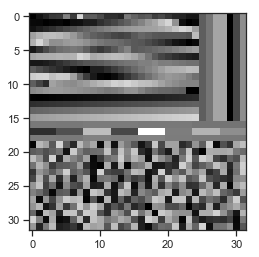

In [9]:
aspa = ASPA_v2(dict_, wavelengths)

plt.imshow(image, cmap='gray', vmin=0, vmax=1.2)

In [11]:
params_original = copy.deepcopy(dict_['param'])
params_original

{'planet_mass': 1.5184e+27,
 'temperature_profile': 1333.3333333333335,
 'ch4_mixratio': 0.0004641588833612782,
 'planet_radius': 66803844.44444445,
 'h2o_mixratio': 3.5938136638046254e-07,
 'co2_mixratio': 0.0027825594022071257,
 'co_mixratio': 0.0027825594022071257}

In [12]:
np.log(2.1544346900318865e-06)

-13.047982193632924

In [13]:
np.exp(-13.047982193632924)

2.154434690031887e-06

No handles with labels found to put in legend.


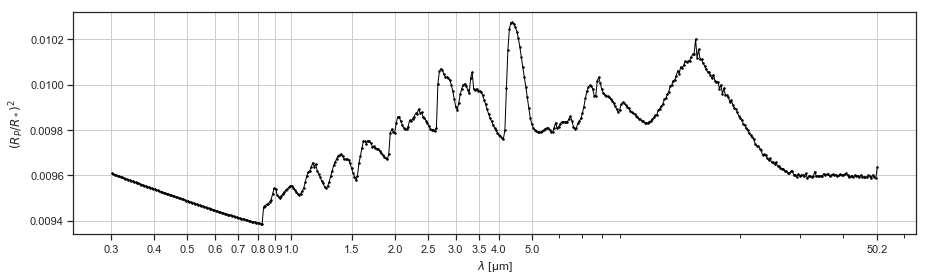

In [14]:
ke.plot_trans(wavelengths, dict_['data']['spectrum'])

(-2.1920944730041847, 16)

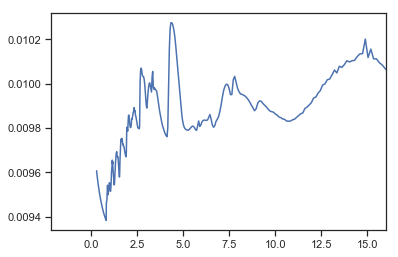

In [15]:
plt.plot(wavelengths, dict_['data']['spectrum'])
plt.xlim(right=16)

# ---------------- Decoding Params from ASPA ------------

In [16]:
def inverse_scale(X_, X_min, X_max):
    """
    X_ is scaled X
    X is unscaled X_
    """
    X = X_ * (X_max - X_min) + X_min
    return X

In [17]:
"""The values of the image parts from the aspa (still encoded)"""
# Grab the values 
spectrum = aspa[:16, :25].flatten()
params = [aspa[:16, 25+i:26+i].mean() for i in range(7)]

In [18]:
"""Decode to arrays"""

# min max values for params used to decode
min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

# Initialize dict to be used for the param values
params_dict = {
    'planet_mass': 0,
    'temp_profile': 0,
    'ch4_mixratio': 0,
    'planet_radius': 0,
    'h2o_mixratio': 0,
    'co2_mixratio': 0,
    'co_mixratio': 0
}

### Decode params

In [19]:
for i,param in enumerate(params_dict):
    # put aspa values in dict
    params_dict[param] = params[i]
    
    # inverse scale these values
    params_dict[param] = inverse_scale(params[i], min_values[i], max_values[i])
    
    # scale mixratios from log back to linear
    if 'mixratio' in param: 
        params_dict[param] = np.exp(params_dict[param])
        print(param, params_dict[param])

params_dict

ch4_mixratio 0.0004641588833612784
h2o_mixratio 3.5938136638046265e-07
co2_mixratio 0.002782559402207122
co_mixratio 0.002782559402207122


{'planet_mass': 1.5184e+27,
 'temp_profile': 1333.3333333333335,
 'ch4_mixratio': 0.0004641588833612784,
 'planet_radius': 66803844.44444445,
 'h2o_mixratio': 3.5938136638046265e-07,
 'co2_mixratio': 0.002782559402207122,
 'co_mixratio': 0.002782559402207122}

# ----- Functionize param decoding -----

In [20]:
def decode_params_from_aspa(aspa):
    """The values of the image parts from the aspa (still encoded)"""
    # Grab the values 
    spectrum = aspa[:16, :25].flatten()
    print("spectrum length: ", len(spectrum))
    params = [aspa[:16, 25+i:26+i].mean() for i in range(7)]
    
    
    """Decode to arrays"""
    # min max values for params used to decode
    min_values = [1.518400e+27, 
                      1.000000e+03, 
                      -1.842068e+01, 
                      5.592880e+07, 
                      -1.842068e+01, 
                      -1.842068e+01, 
                      -1.842068e+01]

    max_values = [3.796000e+27, 
                      2.000000e+03, 
                      -2.302585e+00, 
                      1.048665e+08, 
                      -2.302585e+00, 
                      -2.302585e+00,
                      -2.302585e+00]

    # Initialize dict to be used for the param values
    params_dict = {
        'planet_mass': 0,
        'temp_profile': 0,
        'ch4_mixratio': 0,
        'planet_radius': 0,
        'h2o_mixratio': 0,
        'co2_mixratio': 0,
        'co_mixratio': 0
    }
    
    
    for i,param in enumerate(params_dict):
        # put aspa values in dict
        params_dict[param] = params[i]

        # inverse scale these values
        params_dict[param] = inverse_scale(params[i], min_values[i], max_values[i])

        # scale mixratios from log back to linear
        if 'mixratio' in param: 
            params_dict[param] = np.exp(params_dict[param])
            #print(param, params_dict[param])
        
    return params_dict

In [21]:
decode_params_from_aspa(aspa)

spectrum length:  400


{'planet_mass': 1.5184e+27,
 'temp_profile': 1333.3333333333335,
 'ch4_mixratio': 0.0004641588833612784,
 'planet_radius': 66803844.44444445,
 'h2o_mixratio': 3.5938136638046265e-07,
 'co2_mixratio': 0.002782559402207122,
 'co_mixratio': 0.002782559402207122}

# ---------------- Decoding Spectrum from ASPA ------------

### Decode min max values for bins

In [22]:
mins_ = [aspa[16:17, i*4:i*4+4].mean() for i in range(8)]
maxs_ = [aspa[18:19, i*4:i*4+4].mean() for i in range(8)]


"""min max std values for spectrum bins"""
mins = [] # globally decoded values
maxs = []
for i in range(8):
    mins.append(inverse_scale(mins_[i], 0.005, 0.03))
    maxs.append(inverse_scale(maxs_[i], 0.005, 0.03))
    
mins

[0.010067949761263496,
 0.009830770501588513,
 0.009803282836900075,
 0.009760780359832515,
 0.009788219622535992,
 0.009579171848933928,
 0.00938367067100982,
 0.009388632502154012]

## Decode bins

In [23]:
"""Select bins"""
df = ke.load_wavelengths()

df.columns = ['x']
df = df.loc[df['x'] <= 16] # select only wavelengths <= 16 (max wavelength ASPA has been encoded with)
df['y'] = spectrum

# Could loop this, but right now this is more visual
bin1 = df[df.x <= 0.8]
bin2 = df[(df.x > 0.8) & (df.x <= 1.3)] # select data between 2 and 4 micron
bin3 = df[(df.x > 1.3) & (df.x <= 2)]
bin4 = df[(df.x > 2) & (df.x <= 4)]
bin5 = df[(df.x > 4) & (df.x <= 6)]
bin6 = df[(df.x > 6) & (df.x <= 10)]
bin7 = df[(df.x > 10) & (df.x <= 14)]
bin8 = df[df.x > 14]

bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]

## Scaled spectrum bins

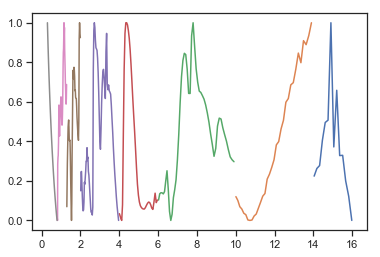

In [24]:
lens = []
for b in bins:
    lens.append(len(b))
    plt.plot(b.x, b.y)

## Scaled bins concatenated

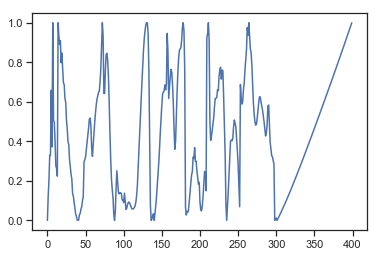

In [25]:
y = np.concatenate([b.y for b in bins])

plt.plot(y)

In [26]:
"""Inverse scale bins"""
for i,b in enumerate(bins):
    b.y = inverse_scale(b.y, mins[i], maxs[i])

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Decoded bins

(0, 16)

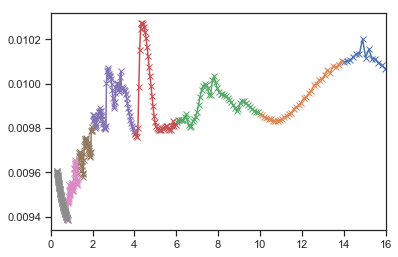

In [27]:
for b in bins:
    plt.plot(b.x, b.y, 'x-')

plt.xlim((0, 16))

## Original spectrum

(515, 1)

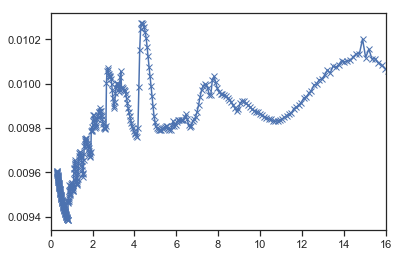

In [28]:
plt.plot(wavelengths, dict_['data']['spectrum'], 'x-')
plt.xlim((0, 16))

np.array(wavelengths).shape

## Decoded spectrum concatenated

In [29]:
x = np.concatenate([b.x for b in bins])
y = np.concatenate([b.y for b in bins])
x.shape, y.shape

((400,), (400,))

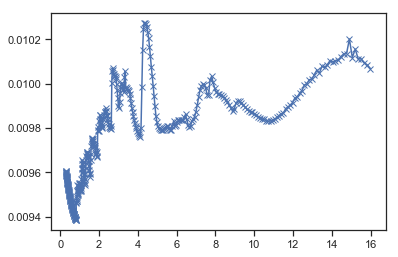

In [30]:
plt.plot(x,y, 'x-')

### Original spectrum
Note that this doesn't have max wavelength set to 16

No handles with labels found to put in legend.


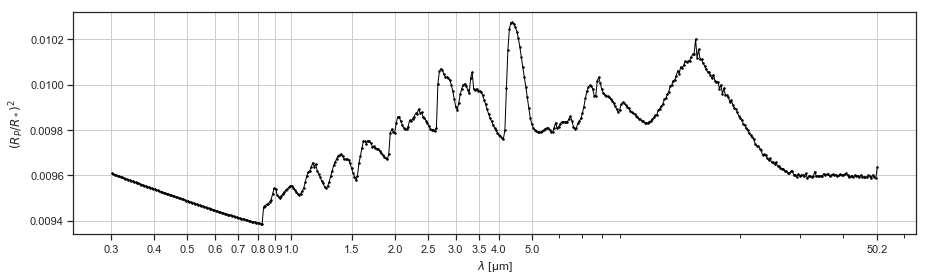

In [37]:
ke.plot_trans(wavelengths, dict_['data']['spectrum'])

### Decoded spectrum

No handles with labels found to put in legend.


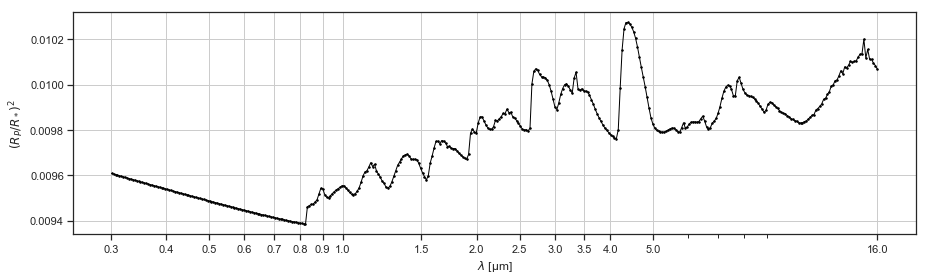

In [38]:
ke.plot_trans(x,y)

# ----- Functionize spectrum decoding -----

In [31]:
def decode_spectrum_from_aspa(aspa, max_wavelength=16):
    """
    Returns x: wavelength in micron, y: R/R 
    It's currently hard coded to work with 
    
        """
        mins_ = [aspa[16:17, i*4:i*4+4].mean() for i in range(8)]
        maxs_ = [aspa[18:19, i*4:i*4+4].mean() for i in range(8)]


        """min max std values for spectrum bins"""
        mins = [] # globally decoded values
        maxs = []
        for i in range(8):
            mins.append(inverse_scale(mins_[i], 0.005, 0.03))
            maxs.append(inverse_scale(maxs_[i], 0.005, 0.03))


    """Select bins"""
    df = ke.load_wavelengths()

    df.columns = ['x']
    df = df.loc[df['x'] <= max_wavelength] # select only wavelengths <= 16 (max wavelength ASPA has been encoded with)
    df['y'] = spectrum

    # Could loop this, but right now this is more visual
    bin1 = df[df.x <= 0.8]
    bin2 = df[(df.x > 0.8) & (df.x <= 1.3)] # select data between 2 and 4 micron
    bin3 = df[(df.x > 1.3) & (df.x <= 2)]
    bin4 = df[(df.x > 2) & (df.x <= 4)]
    bin5 = df[(df.x > 4) & (df.x <= 6)]
    bin6 = df[(df.x > 6) & (df.x <= 10)]
    bin7 = df[(df.x > 10) & (df.x <= 14)]
    bin8 = df[df.x > 14]

    bins = [bin8, bin7, bin6, bin5, bin4, bin3, bin2, bin1]

    """Inverse scale bins"""
    for i,b in enumerate(bins):
        b.y = inverse_scale(b.y, mins[i], maxs[i])

    x = np.concatenate([b.x for b in bins])
    y = np.concatenate([b.y for b in bins])

    return x, y